In [7]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from joblib import dump, load
from sklearn import feature_selection

In [8]:
bot_s = pd.read_csv('./csv_generated/bot_s.csv')
bot_v = pd.read_csv('./csv_generated/bot_v.csv')
bot_z = pd.read_csv('./csv_generated/bot_z.csv')

# remove ambiguous flows (flows having srcIP and dstIP not belonging to IP list)
bot_s = bot_s[bot_s['IPMARK']>-1]

# ignore last column for bot files
bot_s = bot_s[bot_s.columns[:-1]]
bot_v = bot_v[bot_v.columns[:-1]]
bot_z = bot_z[bot_z.columns[:-1]]
bot_v = bot_v.append([bot_v]*100,ignore_index=True)

In [9]:
# clip high data flows
cols = ['F4', 'F5', 'F6']
bot_s[cols] = bot_s[cols].clip(upper=20000)
bot_v[cols] = bot_v[cols].clip(upper=20000)
bot_z[cols] = bot_z[cols].clip(upper=20000)

In [10]:
print(len(bot_s))
print(len(bot_v))
print(len(bot_z))

205538
1010
15973


In [12]:
ben_1 = pd.read_csv('./csv_generated/ben_1.csv')
ben_2 = pd.read_csv('./csv_generated/ben_2.csv')
ben_t = pd.read_csv('./csv_generated/ben_t.csv')

In [13]:
# ignore the last column for benign files
ben_1 = ben_1[ben_1.columns[:-1]]
ben_2 = ben_2[ben_2.columns[:-1]]
ben_t = ben_t[ben_t.columns[:-1]]

In [14]:
# clip high data flows
cols = ['F4', 'F5', 'F6']
ben_1[cols] = ben_1[cols].clip(upper=20000)
ben_2[cols] = ben_2[cols].clip(upper=20000)
ben_t[cols] = ben_t[cols].clip(upper=20000)

In [15]:
print(len(ben_1))
print(len(ben_2))
print(len(ben_t))

17224
31039
1375


In [16]:
# only take 40k instances from storm data to make a balanced dataset
bot_np = np.concatenate([bot_s.sample(40000).to_numpy()[:, :-5], bot_v.to_numpy()[:, :-5], bot_z.to_numpy()[:, :-5]], axis=0)

In [17]:
ben_np = np.concatenate([ben_1.to_numpy()[:, :-5], ben_2.to_numpy()[:, :-5], ben_t.to_numpy()[:, :-5]], axis=0)

In [18]:
pos_labels = np.ones([len(bot_np), 1])
bot_np = np.concatenate([pos_labels, bot_np], axis=-1)
print(bot_np.shape)

(56983, 19)


In [19]:
neg_labels = np.zeros([len(ben_np), 1])
ben_np = np.concatenate([neg_labels, ben_np], axis=-1)
print(ben_np.shape)

(49638, 19)


In [20]:
all_points = np.concatenate([bot_np, ben_np], axis=0)
np.random.shuffle(all_points)
print(all_points)

[[1.0 75.6815287027027 16 ... 8.00000009348878e-06 2800.216562 102.7935]
 [1.0 604.382640333332 2 ... 1812.8909500000007 1812.9044909999936
  1812.9044909999936]
 [0.0 510.50151166666666 2 ... 1531.5043340000002 1531.4565160000002
  1531.4565160000002]
 ...
 [1.0 653.3945713333378 2 ... 1959.9663880000005 1959.9673880000191
  1959.9673880000191]
 [0.0 567.0390943333333 2 ... 1700.8348729999998 1700.8363140000001
  1700.8363140000001]
 [1.0 76.68606220000002 31 ... 12.546537999999998 1211.81554
  11.764170999999974]]


In [21]:
X, y = all_points[:, 1:], all_points[:, 0]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [24]:
# dump(scaler, 'botnet_classifiy_scaler.joblib')

In [25]:
# scaler.var_

In [26]:
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

In [27]:
# np.savetxt('features.tsv', x_train, delimiter='\t')
# np.savetxt('labels.tsv', y_train, delimiter='\t')

In [28]:
pca = PCA(n_components=x_train.shape[1]).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
pca.explained_variance_ratio_

array([3.03710438e-01, 2.08994917e-01, 1.19454386e-01, 6.17285670e-02,
       5.55398143e-02, 4.81795261e-02, 4.07041728e-02, 3.17447889e-02,
       2.99410616e-02, 2.82001833e-02, 2.26708100e-02, 1.55580289e-02,
       1.14562260e-02, 9.32406744e-03, 5.97730408e-03, 4.72959248e-03,
       2.08611572e-03, 1.13187486e-34])

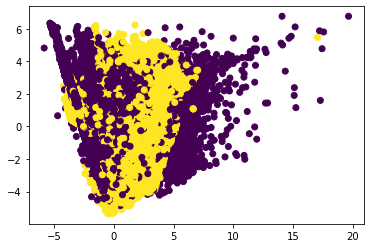

In [29]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train)

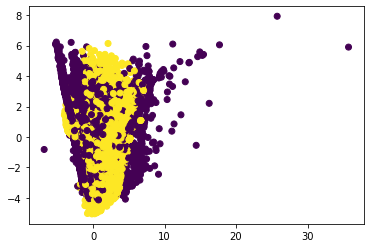

In [30]:
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test)

In [31]:
print(x_train.dtype)
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

float64


In [32]:
information_gain = feature_selection.mutual_info_classif(x_train, y_train)

In [33]:
information_gain

array([0.2369473 , 0.18208728, 0.2004146 , 0.33959894, 0.31583774,
       0.38432709, 0.59655725, 0.63270347, 0.1152926 , 0.56499924,
       0.07853885, 0.2369473 , 0.08816265, 0.08481128, 0.1064014 ,
       0.35279535, 0.09854321, 0.30734012])

In [34]:
classifier = RandomForestClassifier(n_estimators=20).fit(x_train, y_train)

In [35]:
# dump(classifier, 'botnet_classifier.joblib')

In [36]:
predictions = classifier.predict(x_test)
predictions_probs = classifier.predict_proba(x_test)

In [37]:
print(f"Train Accuracy = {classifier.score(x_train, y_train)}")
print(f"Test Accuracy = {classifier.score(x_test, y_test)}")
print(f"Precision = {sklearn.metrics.precision_score(y_test, predictions)}")
print(f"Recall = {sklearn.metrics.recall_score(y_test, predictions)}")
print(f"ROC AUC = {sklearn.metrics.roc_auc_score(y_test, predictions_probs[:,1])}")

Train Accuracy = 0.9999874945288564
Test Accuracy = 0.9996623649459784
Precision = 0.9998588368153586
Recall = 0.9995061031538841
ROC AUC = 0.9999977165021477


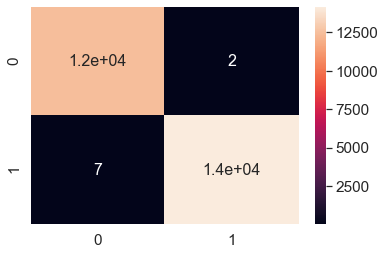

In [38]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()